In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchinfo import summary
from tqdm import tqdm

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from pandas import read_csv

In [2]:
import random
import os

seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
# torch.use_deterministic_algorithms(True)

'cuda'

# Loading Dataset

In [3]:
train = pd.read_csv('/kaggle/input/har-using-deep-nn/train.csv')
train.sample()

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,...,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject,Activity,ActivityName
4525,0.283203,-0.047024,-0.168986,0.384949,0.176898,-0.310332,0.381757,0.122611,-0.332984,0.465563,...,-0.034924,0.558036,0.258975,-0.854858,-0.78433,0.22296,-0.066506,22,3,WALKING_DOWNSTAIRS


In [4]:
train.shape

(7352, 564)

In [5]:
test = pd.read_csv('/kaggle/input/har-using-deep-nn/test.csv')
test.sample()

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,...,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject,Activity,ActivityName
718,0.3659,-0.031332,-0.024079,0.183421,-0.344568,-0.403268,0.09989,-0.3422,-0.412337,0.4803,...,-0.37837,-0.840289,-0.864326,0.848585,-0.960939,0.116422,-0.003858,9,3,WALKING_DOWNSTAIRS


In [6]:
test.shape

(2947, 564)

In [7]:
print('Duplicates in train = {}'.format(sum(train.duplicated())))
print('Duplicates in test = {}'.format(sum(test.duplicated())))
print('Invalid values in train = {}'.format(train.isnull().values.sum()))
print('Invalid values in test = {}'.format(test.isnull().values.sum()))

Duplicates in train = 0
Duplicates in test = 0
Invalid values in train = 0
Invalid values in test = 0


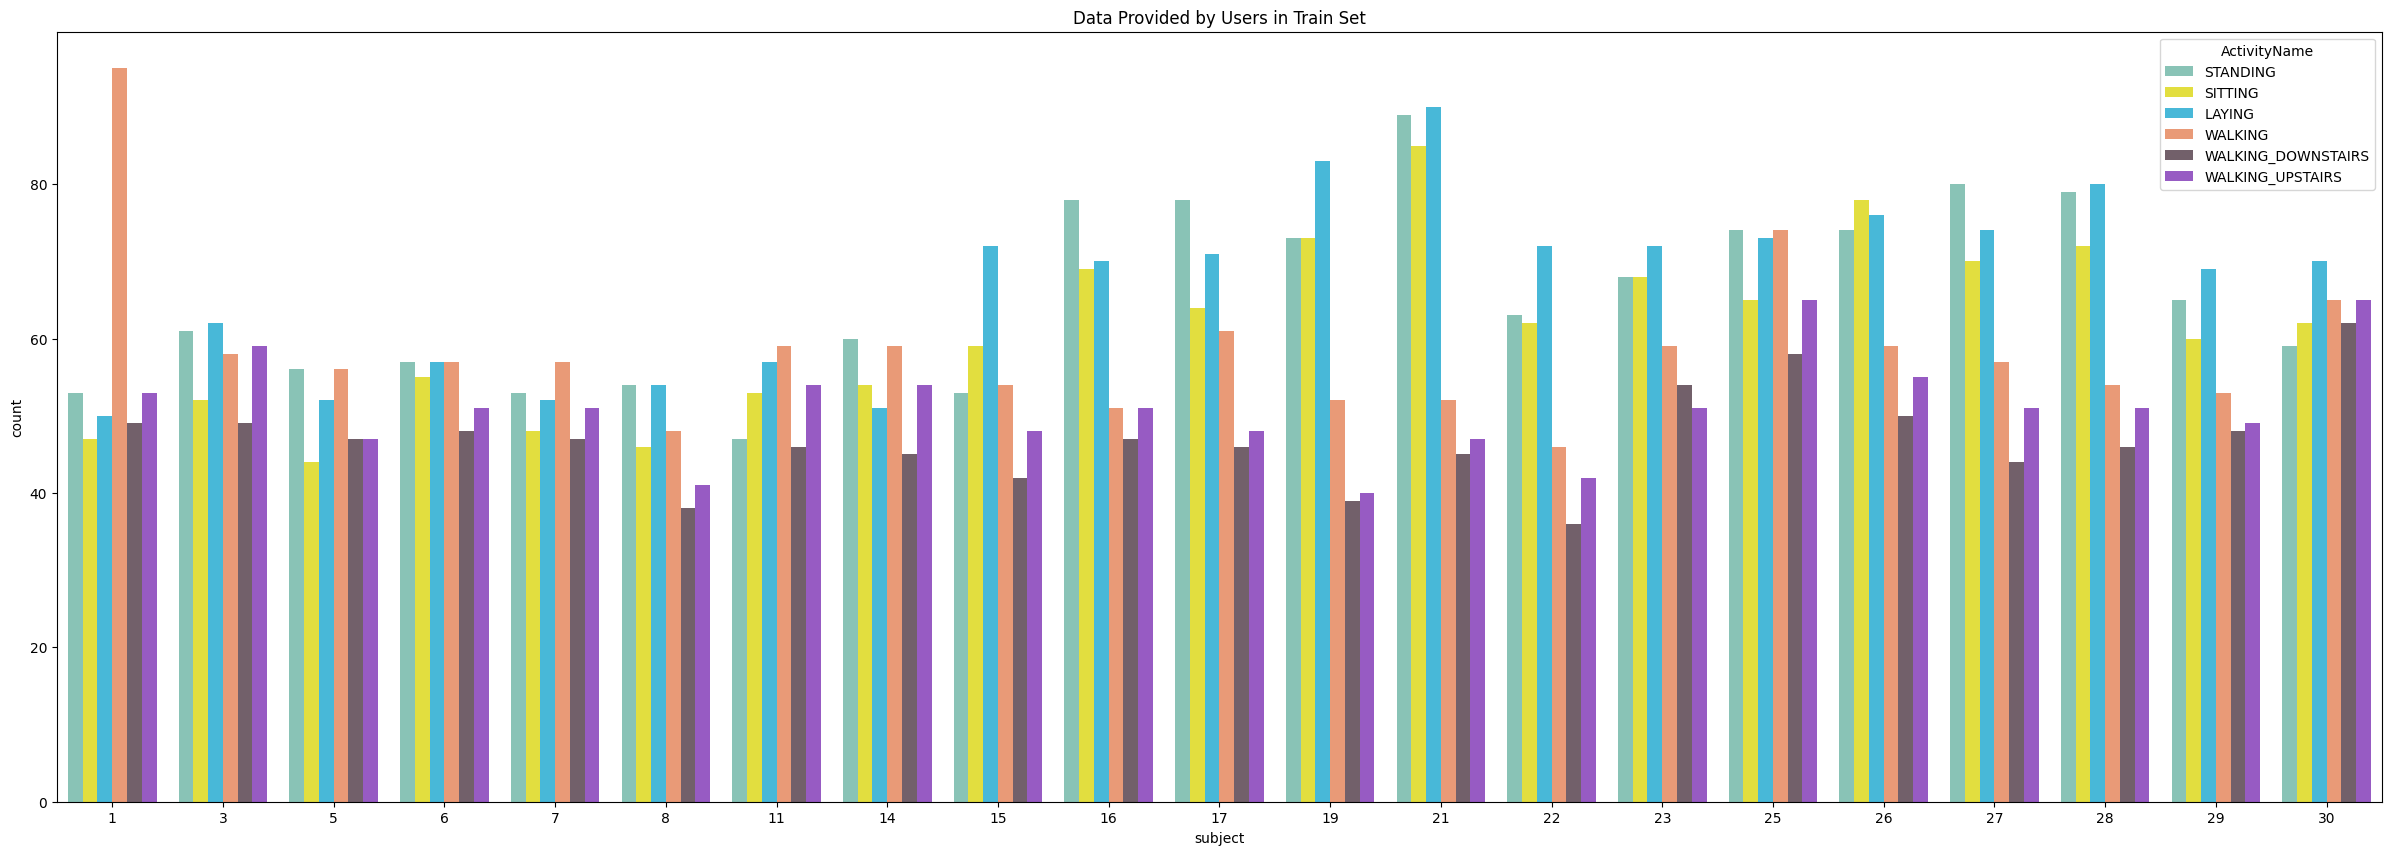

In [8]:
plt.figure(figsize=(30,10))
sns.countplot(x='subject',hue='ActivityName',palette= ["#7fcdbb","#fdf824","#30c6f0","#fc9264","#755d6b","#9a4ad4"], data = train)
plt.title('Data Provided by Users in Train Set')
plt.show()

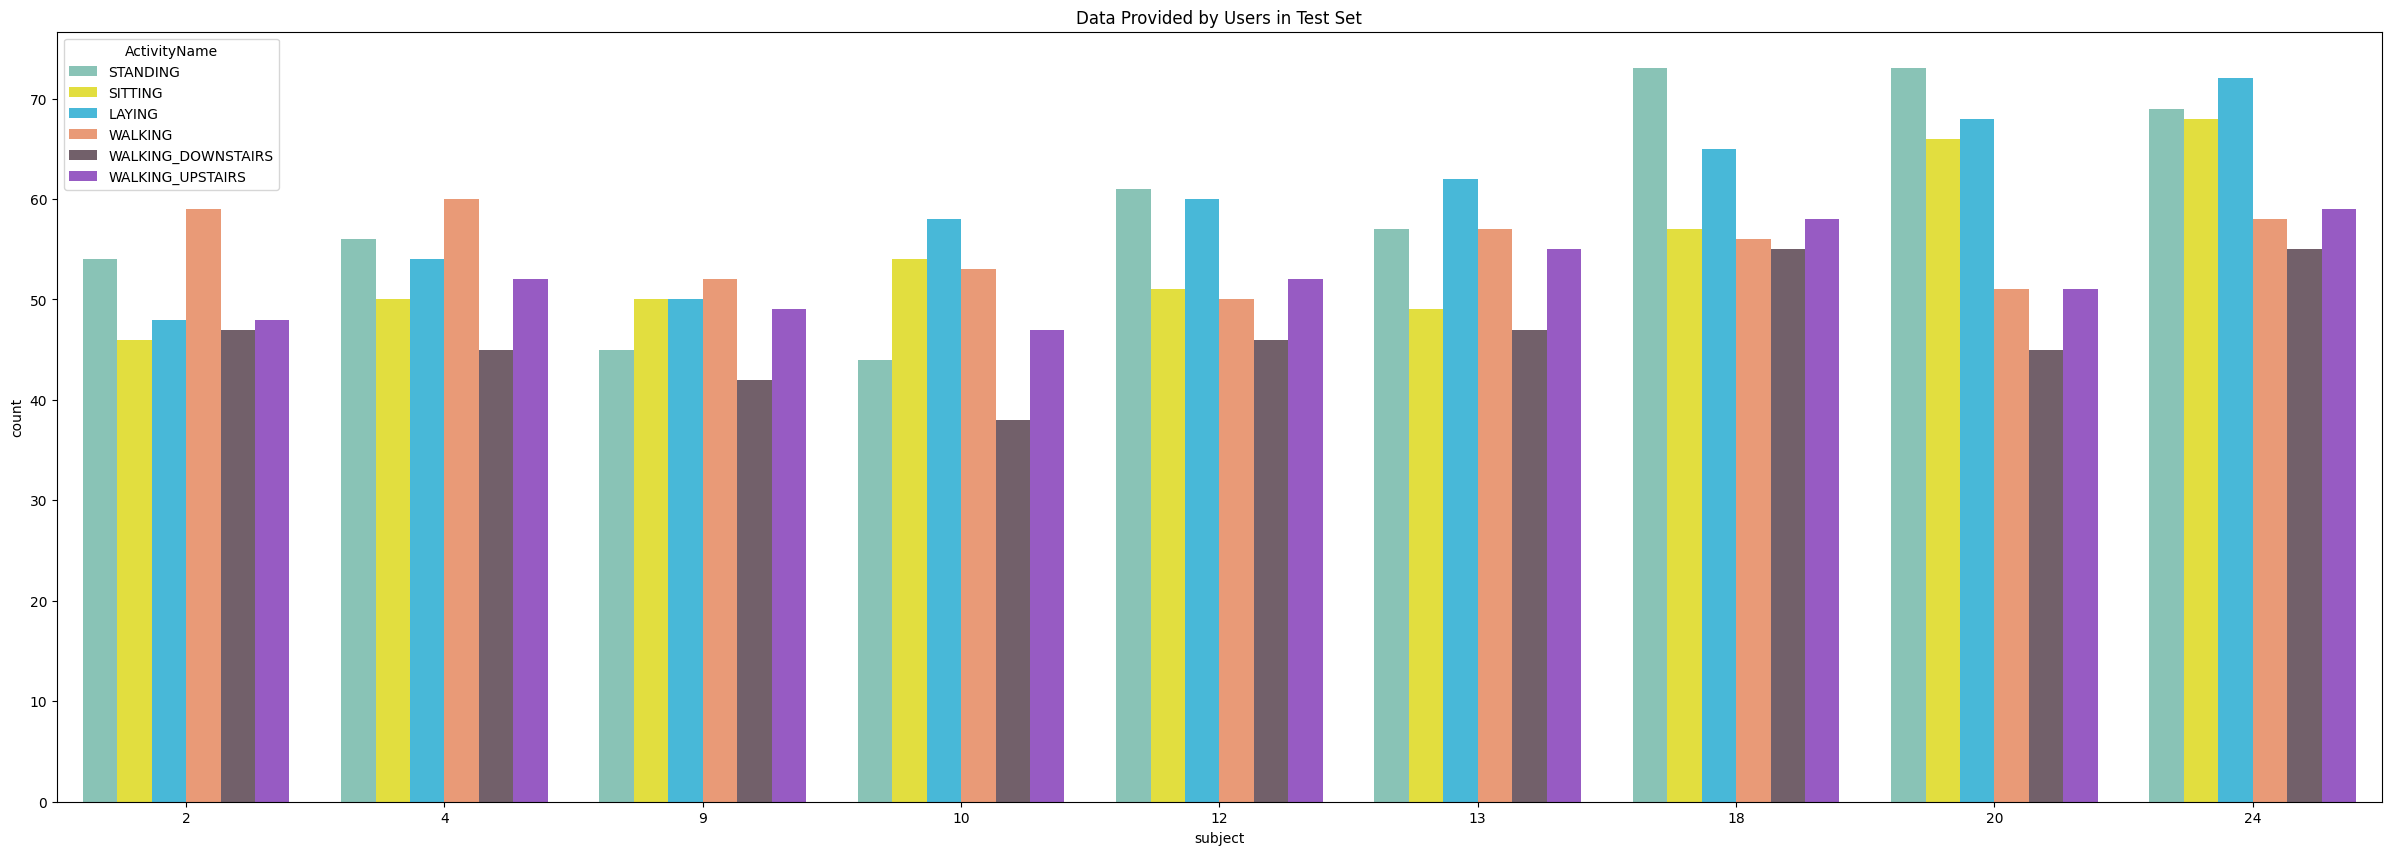

In [9]:
plt.figure(figsize=(30,10))
sns.countplot(x='subject',hue='ActivityName',palette= ["#7fcdbb","#fdf824","#30c6f0","#fc9264","#755d6b","#9a4ad4"], data = test)
plt.title('Data Provided by Users in Test Set')
plt.show()

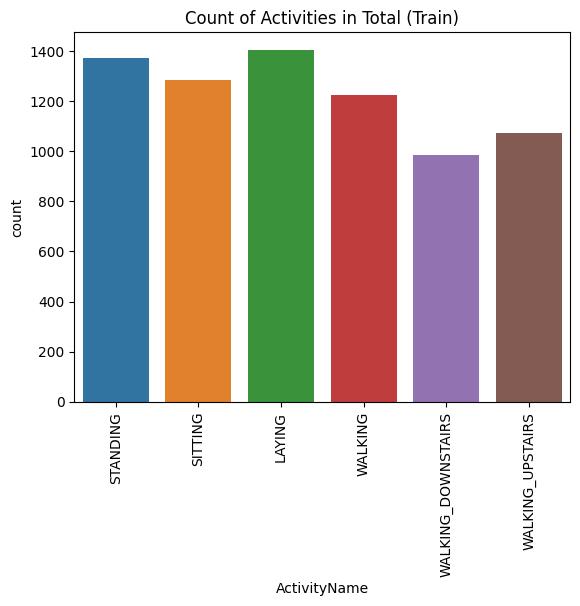

In [10]:
plt.title('Count of Activities in Total (Train)')
sns.countplot(x="ActivityName",data=train)
plt.xticks(rotation=90)
plt.show()

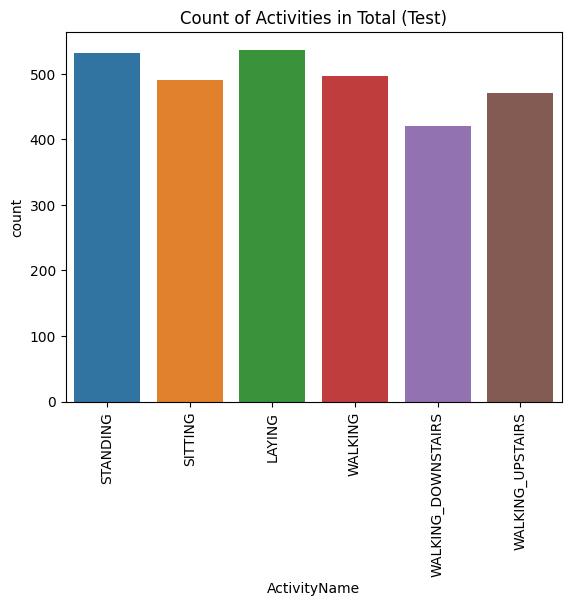

In [11]:
plt.title('Count of Activities in Total (Test)')
sns.countplot(x="ActivityName",data=test)
plt.xticks(rotation=90)
plt.show()

In [12]:
def file_load(filepath):
    df = read_csv(filepath, header=None, sep='\s+')
    return df.values

In [13]:
def train_test_append(filenames, append_before=''):
    datalist = list()
    for name in filenames:
        data = file_load(append_before + name)
        datalist.append(data)
    datalist = np.dstack(datalist)
    return datalist

In [14]:
def inertial_signals_load(group, append_before=''):
    filepath = append_before + group + '/Inertial Signals/'
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = train_test_append(filenames, filepath)
    y = file_load(append_before + group + '/y_'+group+'.txt')
    return X, y

In [15]:
def load_dataset(append_before=''):
    trainX, trainy = inertial_signals_load('train', append_before + '/kaggle/input/ucihar-dataset/UCI-HAR Dataset/')
    testX, testy = inertial_signals_load('test', append_before + '/kaggle/input/ucihar-dataset/UCI-HAR Dataset/')
    trainy = trainy - 1
    testy = testy - 1
    trainy = pd.get_dummies(trainy[:,0], dtype=int).values
    testy = pd.get_dummies(testy[:,0], dtype=int).values
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

In [16]:
trainX, trainy, testX, testy = load_dataset()
verbose, epochs, batch_size = 0, 100, 200
n_timesteps = trainX.shape[1]
n_features = trainX.shape[2]
n_outputs = trainy.shape[1]
# n_steps = 4
# n_length = 32
# trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
# testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features)) 
print(trainX.shape,testX.shape)

(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
(7352, 128, 9) (2947, 128, 9)


## Setting Up the train and test loaders

In [17]:
class HARDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [18]:
train_dataset = HARDataset(trainX, trainy)
test_dataset = HARDataset(testX, testy)

BATCH = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)

# Modelling

## Loss Function

In [19]:
def kl_divergence_loss(preds, targets):
    # Ensure that the predictions and targets are probabilities
    preds = F.softmax(preds, dim=-1)
    targets = F.softmax(targets, dim=-1)
    loss = F.kl_div(preds.log(), targets, reduction='batchmean')
    return loss

def mse_loss(preds, targets):
    # Ensure that the predictions and targets are one-hot encoded
    preds = F.softmax(preds, dim=-1)
    return F.mse_loss(preds, targets)

# Focal Loss
def focal_loss(preds, targets, alpha=0.25, gamma=2.0):
    """
    Focal Loss for multi-class classification.
    
    Arguments:
    preds -- the raw logits from the model (shape: [batch_size, num_classes])
    targets -- the true labels (shape: [batch_size])
    alpha -- balancing factor for class imbalances (default is 0.25)
    gamma -- focusing parameter (default is 2.0)
    
    Returns:
    loss -- the computed focal loss
    """
    # Apply softmax to get probabilities
    preds = F.softmax(preds, dim=-1)
    
    # Convert targets to one-hot encoding
    targets_one_hot = targets
    
    # Cross-entropy loss
    ce_loss = F.cross_entropy(preds, targets, reduction='none')
    
    # Get the predicted probability for the correct class
    pt = torch.exp(-ce_loss)
    
    # Compute focal loss
    focal_loss = alpha * (1 - pt) ** gamma * ce_loss
    
    return focal_loss.mean()

# criterion = nn.CrossEntropyLoss() # -> 96.89% 93.55%
# criterion = kl_divergence_loss # -> 99.09% 94.81%
# criterion = mse_loss # -> 96.27% 92.94%
# criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # -> 97.43% 94.06%
# criterion = focal_loss # -> 97.27% 93.32%

## Optimizer and Learning Rate

In [20]:
def warmup_lr(epoch, step_size, warmup_epochs=5, gamma=0.1):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    
    else:
        epoch_since_warmup = epoch - warmup_epochs
        return gamma ** (epoch_since_warmup // step_size)

WARMUP_EPOCHS = 14
GAMMA = 0.1
STEP_SIZE = 20

## Plotting Train and Test Acc and Loss

In [21]:
# Plot history
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss History')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy History')

    plt.show()

## Confusion Matrix Function

In [22]:
def plot_confusion_matrix(model, val_loader, class_names, device="cuda"):
    """
    Evaluates the model and plots a confusion matrix with a custom color map.

    Arguments:
    - model: Trained PyTorch model.
    - val_loader: DataLoader for validation dataset.
    - class_names: List of class names for the confusion matrix.
    - device: 'cuda' or 'cpu'.
    """
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)  # Predicted classes
            
            # If labels are one-hot encoded, convert them to class indices
            if len(labels.shape) > 1 and labels.size(1) > 1:
                labels = torch.argmax(labels, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot the confusion matrix with customization
    fig, ax = plt.subplots(figsize=(10, 8))  # Set larger figure size
    disp.plot(cmap="YlGnBu", ax=ax, colorbar=True)  # Use "cividis" colormap and add colorbar
    plt.title("Confusion Matrix", fontsize=16)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.show()

## Training Function

In [23]:
def train_model(model, train_loader, val_loader, criterion=None, epochs=20, device='cpu', early_stopping=False):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    patience = 20
    min_delta = 1e-6
    best_loss = np.inf
    patience_counter = 0

    if criterion is None:
        criterion = F.mse_loss
    _criterion = criterion
    
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        
        # Training phase
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", unit="batch") as tepoch:
            for inputs, targets in tepoch:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = _criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() * inputs.size(0)
                train_correct += (outputs.argmax(1) == targets.argmax(1)).sum().item()

                tepoch.set_postfix(loss=loss.item())

        scheduler.step()

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            with tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation", unit="batch") as vepoch:
                for inputs, targets in vepoch:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)
                    val_correct += (outputs.argmax(1) == targets.argmax(1)).sum().item()

                    vepoch.set_postfix(loss=loss.item())

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_loss - min_delta:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1


        if patience_counter >= patience and early_stopping and epoch > 100:
            print("Early stopping triggered!")
            break

    return history

## Models

### RNN + Attention

In [24]:
class AdaptiveRNN(nn.Module):
    def __init__(self, n_timesteps, n_features, n_outputs):
        super(AdaptiveRNN, self).__init__()

        # Bi-directional LSTM layer
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=128,
            batch_first=True,
            bidirectional=True
        )
        self.batch_norm = nn.BatchNorm1d(128 * 2)

        # Attention mechanism
        self.attention_dense = nn.Linear(128 * 2, 1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_outputs)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # LSTM output
        lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch_size, timesteps, 128*2)
        
        batch_size, n_timesteps, n_features = lstm_out.size()
        lstm_out = lstm_out.reshape(batch_size * n_timesteps, n_features)
        lstm_out = self.batch_norm(lstm_out)
        lstm_out = lstm_out.reshape(batch_size, n_timesteps, n_features)
        
        # Attention mechanism
        attention_scores = torch.sigmoid(self.attention_dense(lstm_out))  # (batch_size, timesteps, 1)
        attention_scores = lstm_out * attention_scores  # Weighted timesteps

        # Global average pooling
        pooled = attention_scores.mean(dim=1)
        
        # Fully connected layers
        x = F.relu(self.fc1(pooled))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.softmax(x, dim=1)

In [ ]:
# Define the model parameters
n_timesteps = 32 * 4  # 128 timesteps
n_features = 9
n_outputs = 6

# Create the model
model = AdaptiveRNN(n_timesteps=n_timesteps, n_features=n_features, n_outputs=n_outputs).to(device)
summary(model)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda x: warmup_lr(x, warmup_epochs=WARMUP_EPOCHS, gamma=GAMMA, step_size=STEP_SIZE))
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 50, eta_min = 1e-6)

history = train_model(model, train_loader, test_loader, criterion=kl_divergence_loss, epochs=150, device=device, early_stopping=False)

In [ ]:
plot_history(history)

### TCN Model

In [25]:
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation_rate):
        super(TCNBlock, self).__init__()

        self.conv1 = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            padding='same',
            dilation=dilation_rate
        )
        self.batch_norm = nn.BatchNorm1d(out_channels)

        # Residual connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = None

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.batch_norm(out)

        shortcut = self.shortcut(x) if self.shortcut is not None else x
        return F.relu(out + shortcut)

class TCNModel(nn.Module):
    def __init__(self, n_length, n_features, n_outputs):
        super(TCNModel, self).__init__()

        self.tcn_blocks = nn.Sequential(
            TCNBlock(n_features, 64, kernel_size=3, dilation_rate=1),
            TCNBlock(64, 128, kernel_size=3, dilation_rate=2),
            TCNBlock(128, 256, kernel_size=3, dilation_rate=4),
            TCNBlock(256, 64, kernel_size=3, dilation_rate=8)
        )

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_outputs)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Convert to (batch_size, n_features, n_length)
        x = self.tcn_blocks(x)

        x = self.global_avg_pool(x).squeeze(-1)  # Global average pooling

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return F.softmax(x, dim=1)

# Define model parameters
n_length = 128  
n_features = 9
n_outputs = 6

In [ ]:
# Instantiate model
model = TCNModel(n_length, n_features, n_outputs).to(device)
summary(model)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda x: warmup_lr(x, warmup_epochs=WARMUP_EPOCHS, gamma=GAMMA, step_size=STEP_SIZE))
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 50, eta_min = 1e-6)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

history = train_model(model, train_loader, test_loader, criterion=kl_divergence_loss, epochs=150, device=device, early_stopping=True)

In [ ]:
plot_history(history)

In [ ]:
plot_confusion_matrix(model, test_loader, class_names=["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"])

### TCN + CBAM Model

In [26]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=8):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Conv1d(in_channels, in_channels // reduction_ratio, kernel_size=1)
        self.fc2 = nn.Conv1d(in_channels // reduction_ratio, in_channels, kernel_size=1)

    def forward(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)

        avg_out = F.relu(self.fc1(avg_pool))
        avg_out = self.fc2(avg_out)

        max_out = F.relu(self.fc1(max_pool))
        max_out = self.fc2(max_out)

        out = avg_out + max_out
        return torch.sigmoid(out) * x  # Channel attention applied

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv1d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_pool, max_pool], dim=1)  # Concatenate along channel dimension
        out = self.conv(x_cat)
        return self.sigmoid(out) * x  # Spatial attention applied

class CBAMBlock(nn.Module):
    def __init__(self, in_channels):
        super(CBAMBlock, self).__init__()
        self.channel_attention = ChannelAttention(in_channels)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

class TCNWithCBAM(nn.Module):
    def __init__(self, n_length, n_features, n_outputs):
        super(TCNWithCBAM, self).__init__()

        self.tcn_blocks = nn.Sequential(
            TCNBlock(n_features, 64, kernel_size=3, dilation_rate=1),
            TCNBlock(64, 64, kernel_size=3, dilation_rate=2),
            TCNBlock(64, 64, kernel_size=3, dilation_rate=4),
            TCNBlock(64, 64, kernel_size=3, dilation_rate=8)
        ) # (batch_size, out_channels, n_length)

        self.cbam_block = CBAMBlock(64)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_outputs)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Convert to (batch_size, n_features, n_length)
        x = self.tcn_blocks(x)

        # Apply CBAM
        x = self.cbam_block(x)

        x = self.global_avg_pool(x).squeeze(-1)  # Global average pooling

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return F.softmax(x, dim=1)

# Define model parameters
n_length = 128  
n_features = 9
n_outputs = 6

In [27]:
model = TCNWithCBAM(n_length, n_features, n_outputs).to(device)
summary(model)

Layer (type:depth-idx)                   Param #
TCNWithCBAM                              --
├─Sequential: 1-1                        --
│    └─TCNBlock: 2-1                     --
│    │    └─Conv1d: 3-1                  1,792
│    │    └─BatchNorm1d: 3-2             128
│    │    └─Conv1d: 3-3                  640
│    └─TCNBlock: 2-2                     --
│    │    └─Conv1d: 3-4                  12,352
│    │    └─BatchNorm1d: 3-5             128
│    └─TCNBlock: 2-3                     --
│    │    └─Conv1d: 3-6                  12,352
│    │    └─BatchNorm1d: 3-7             128
│    └─TCNBlock: 2-4                     --
│    │    └─Conv1d: 3-8                  12,352
│    │    └─BatchNorm1d: 3-9             128
├─CBAMBlock: 1-2                         --
│    └─ChannelAttention: 2-5             --
│    │    └─AdaptiveAvgPool1d: 3-10      --
│    │    └─AdaptiveMaxPool1d: 3-11      --
│    │    └─Conv1d: 3-12                 520
│    │    └─Conv1d: 3-13                 576
│    

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

history = train_model(model, train_loader, test_loader, criterion=kl_divergence_loss, epochs=150, device=device, early_stopping=True)

Epoch 1/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 142.29batch/s, loss=0.0723]


Epoch 1/150 - Train Loss: 0.0852, Train Acc: 0.4218 - Val Loss: 0.0825, Val Acc: 0.5677


Epoch 2/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 156.76batch/s, loss=0.0242]


Epoch 2/150 - Train Loss: 0.0521, Train Acc: 0.6521 - Val Loss: 0.0421, Val Acc: 0.7024


Epoch 3/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 158.86batch/s, loss=0.00172]


Epoch 3/150 - Train Loss: 0.0285, Train Acc: 0.8787 - Val Loss: 0.0197, Val Acc: 0.9046


Epoch 4/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 152.75batch/s, loss=3.45e-5]


Epoch 4/150 - Train Loss: 0.0122, Train Acc: 0.9377 - Val Loss: 0.0151, Val Acc: 0.9172


Epoch 5/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 169.61batch/s, loss=9.13e-5]


Epoch 5/150 - Train Loss: 0.0094, Train Acc: 0.9516 - Val Loss: 0.0152, Val Acc: 0.9128


Epoch 6/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 170.87batch/s, loss=4.57e-6]


Epoch 6/150 - Train Loss: 0.0087, Train Acc: 0.9523 - Val Loss: 0.0125, Val Acc: 0.9247


Epoch 7/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 160.25batch/s, loss=6.15e-6]


Epoch 7/150 - Train Loss: 0.0084, Train Acc: 0.9529 - Val Loss: 0.0132, Val Acc: 0.9240


Epoch 8/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 170.14batch/s, loss=1.03e-5]


Epoch 8/150 - Train Loss: 0.0074, Train Acc: 0.9589 - Val Loss: 0.0126, Val Acc: 0.9304


Epoch 9/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 159.39batch/s, loss=-1.64e-8]


Epoch 9/150 - Train Loss: 0.0072, Train Acc: 0.9603 - Val Loss: 0.0134, Val Acc: 0.9298


Epoch 10/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 168.22batch/s, loss=5.99e-5]


Epoch 10/150 - Train Loss: 0.0067, Train Acc: 0.9635 - Val Loss: 0.0133, Val Acc: 0.9301


Epoch 11/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 167.40batch/s, loss=7.14e-8]


Epoch 11/150 - Train Loss: 0.0068, Train Acc: 0.9603 - Val Loss: 0.0145, Val Acc: 0.9203


Epoch 12/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 151.51batch/s, loss=2.74e-6]


Epoch 12/150 - Train Loss: 0.0062, Train Acc: 0.9635 - Val Loss: 0.0154, Val Acc: 0.9189


Epoch 13/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 165.00batch/s, loss=4.95e-6]


Epoch 13/150 - Train Loss: 0.0064, Train Acc: 0.9623 - Val Loss: 0.0132, Val Acc: 0.9264


Epoch 14/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 170.57batch/s, loss=1.12e-6]


Epoch 14/150 - Train Loss: 0.0054, Train Acc: 0.9668 - Val Loss: 0.0129, Val Acc: 0.9348


Epoch 15/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 171.43batch/s, loss=1.24e-6]


Epoch 15/150 - Train Loss: 0.0049, Train Acc: 0.9714 - Val Loss: 0.0135, Val Acc: 0.9281


Epoch 16/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 164.47batch/s, loss=-2.21e-8]


Epoch 16/150 - Train Loss: 0.0049, Train Acc: 0.9724 - Val Loss: 0.0125, Val Acc: 0.9342


Epoch 17/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 158.13batch/s, loss=8.57e-7]


Epoch 17/150 - Train Loss: 0.0053, Train Acc: 0.9686 - Val Loss: 0.0159, Val Acc: 0.9179


Epoch 18/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 173.61batch/s, loss=1.44e-6]


Epoch 18/150 - Train Loss: 0.0048, Train Acc: 0.9729 - Val Loss: 0.0136, Val Acc: 0.9267


Epoch 19/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 169.38batch/s, loss=-3.82e-8]


Epoch 19/150 - Train Loss: 0.0043, Train Acc: 0.9746 - Val Loss: 0.0121, Val Acc: 0.9399


Epoch 20/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 168.40batch/s, loss=-3.41e-8]


Epoch 20/150 - Train Loss: 0.0046, Train Acc: 0.9728 - Val Loss: 0.0132, Val Acc: 0.9291


Epoch 21/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 169.53batch/s, loss=-3.03e-8]


Epoch 21/150 - Train Loss: 0.0045, Train Acc: 0.9724 - Val Loss: 0.0123, Val Acc: 0.9359


Epoch 22/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 167.86batch/s, loss=-5.55e-8]


Epoch 22/150 - Train Loss: 0.0043, Train Acc: 0.9752 - Val Loss: 0.0137, Val Acc: 0.9294


Epoch 23/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 168.64batch/s, loss=-3.64e-8]


Epoch 23/150 - Train Loss: 0.0046, Train Acc: 0.9744 - Val Loss: 0.0114, Val Acc: 0.9430


Epoch 24/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 160.38batch/s, loss=-3.41e-8]


Epoch 24/150 - Train Loss: 0.0038, Train Acc: 0.9784 - Val Loss: 0.0116, Val Acc: 0.9399


Epoch 25/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 169.92batch/s, loss=-3e-8]


Epoch 25/150 - Train Loss: 0.0035, Train Acc: 0.9777 - Val Loss: 0.0116, Val Acc: 0.9389


Epoch 26/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 172.05batch/s, loss=-2.75e-8]


Epoch 26/150 - Train Loss: 0.0037, Train Acc: 0.9777 - Val Loss: 0.0114, Val Acc: 0.9410


Epoch 27/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 172.15batch/s, loss=-1.82e-9]


Epoch 27/150 - Train Loss: 0.0034, Train Acc: 0.9793 - Val Loss: 0.0111, Val Acc: 0.9386


Epoch 28/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 57.25batch/s, loss=-8.42e-9]


Epoch 28/150 - Train Loss: 0.0035, Train Acc: 0.9807 - Val Loss: 0.0117, Val Acc: 0.9396


Epoch 29/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 170.36batch/s, loss=-2.62e-8]


Epoch 29/150 - Train Loss: 0.0035, Train Acc: 0.9791 - Val Loss: 0.0114, Val Acc: 0.9396


Epoch 30/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 161.32batch/s, loss=-3.66e-8]


Epoch 30/150 - Train Loss: 0.0031, Train Acc: 0.9819 - Val Loss: 0.0117, Val Acc: 0.9410


Epoch 31/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 171.94batch/s, loss=-2.39e-8]


Epoch 31/150 - Train Loss: 0.0028, Train Acc: 0.9831 - Val Loss: 0.0116, Val Acc: 0.9406


Epoch 32/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 162.67batch/s, loss=-3.82e-8]


Epoch 32/150 - Train Loss: 0.0031, Train Acc: 0.9822 - Val Loss: 0.0121, Val Acc: 0.9365


Epoch 33/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 171.65batch/s, loss=-1.87e-8]


Epoch 33/150 - Train Loss: 0.0029, Train Acc: 0.9819 - Val Loss: 0.0114, Val Acc: 0.9420


Epoch 34/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 159.23batch/s, loss=-3.3e-8]


Epoch 34/150 - Train Loss: 0.0031, Train Acc: 0.9816 - Val Loss: 0.0119, Val Acc: 0.9396


Epoch 35/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 168.54batch/s, loss=-3.39e-8]


Epoch 35/150 - Train Loss: 0.0030, Train Acc: 0.9829 - Val Loss: 0.0123, Val Acc: 0.9345


Epoch 36/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 160.22batch/s, loss=-1.46e-8]


Epoch 36/150 - Train Loss: 0.0029, Train Acc: 0.9822 - Val Loss: 0.0130, Val Acc: 0.9321


Epoch 37/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 175.98batch/s, loss=-3.03e-8]


Epoch 37/150 - Train Loss: 0.0030, Train Acc: 0.9822 - Val Loss: 0.0124, Val Acc: 0.9365


Epoch 38/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 159.78batch/s, loss=-2.02e-8]


Epoch 38/150 - Train Loss: 0.0026, Train Acc: 0.9846 - Val Loss: 0.0125, Val Acc: 0.9332


Epoch 39/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 168.69batch/s, loss=-3.73e-8]


Epoch 39/150 - Train Loss: 0.0027, Train Acc: 0.9827 - Val Loss: 0.0124, Val Acc: 0.9372


Epoch 40/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 175.15batch/s, loss=-2.8e-8]


Epoch 40/150 - Train Loss: 0.0025, Train Acc: 0.9864 - Val Loss: 0.0125, Val Acc: 0.9342


Epoch 41/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 169.60batch/s, loss=-3.62e-8]


Epoch 41/150 - Train Loss: 0.0025, Train Acc: 0.9848 - Val Loss: 0.0126, Val Acc: 0.9338


Epoch 42/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 168.15batch/s, loss=-2.57e-8]


Epoch 42/150 - Train Loss: 0.0023, Train Acc: 0.9865 - Val Loss: 0.0127, Val Acc: 0.9359


Epoch 43/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 166.16batch/s, loss=-3.28e-8]


Epoch 43/150 - Train Loss: 0.0025, Train Acc: 0.9857 - Val Loss: 0.0124, Val Acc: 0.9362


Epoch 44/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 174.33batch/s, loss=-1.82e-8]


Epoch 44/150 - Train Loss: 0.0024, Train Acc: 0.9864 - Val Loss: 0.0126, Val Acc: 0.9355


Epoch 45/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 172.42batch/s, loss=-2.93e-8]


Epoch 45/150 - Train Loss: 0.0022, Train Acc: 0.9871 - Val Loss: 0.0128, Val Acc: 0.9362


Epoch 46/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 170.33batch/s, loss=-2.91e-8]


Epoch 46/150 - Train Loss: 0.0020, Train Acc: 0.9887 - Val Loss: 0.0126, Val Acc: 0.9362


Epoch 47/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 166.41batch/s, loss=-3.55e-8]


Epoch 47/150 - Train Loss: 0.0021, Train Acc: 0.9868 - Val Loss: 0.0127, Val Acc: 0.9352


Epoch 48/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 157.43batch/s, loss=-3.37e-8]


Epoch 48/150 - Train Loss: 0.0021, Train Acc: 0.9880 - Val Loss: 0.0127, Val Acc: 0.9359


Epoch 49/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 162.02batch/s, loss=-2.84e-8]


Epoch 49/150 - Train Loss: 0.0022, Train Acc: 0.9879 - Val Loss: 0.0128, Val Acc: 0.9348


Epoch 50/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 158.46batch/s, loss=-2.71e-8]


Epoch 50/150 - Train Loss: 0.0020, Train Acc: 0.9888 - Val Loss: 0.0127, Val Acc: 0.9345


Epoch 51/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 174.54batch/s, loss=-3.44e-8]


Epoch 51/150 - Train Loss: 0.0022, Train Acc: 0.9874 - Val Loss: 0.0127, Val Acc: 0.9348


Epoch 52/150 - Validation:   0%|          | 0/12 [00:00<?, ?batch/s]

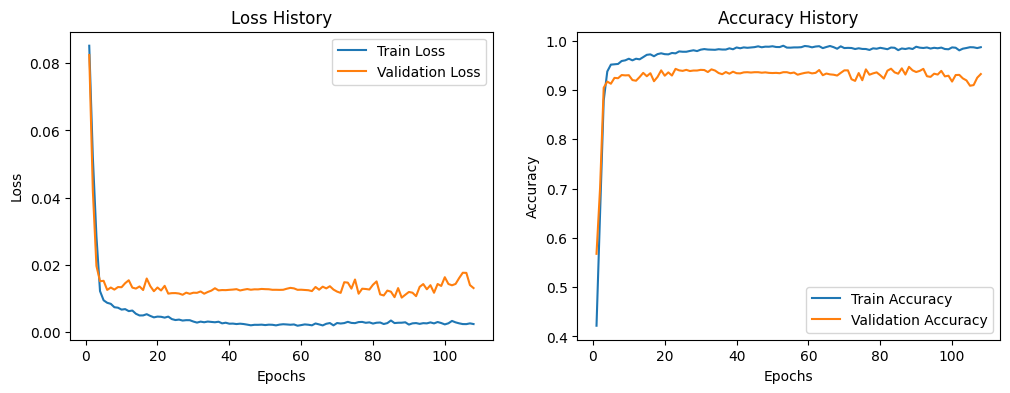

In [29]:
plot_history(history)

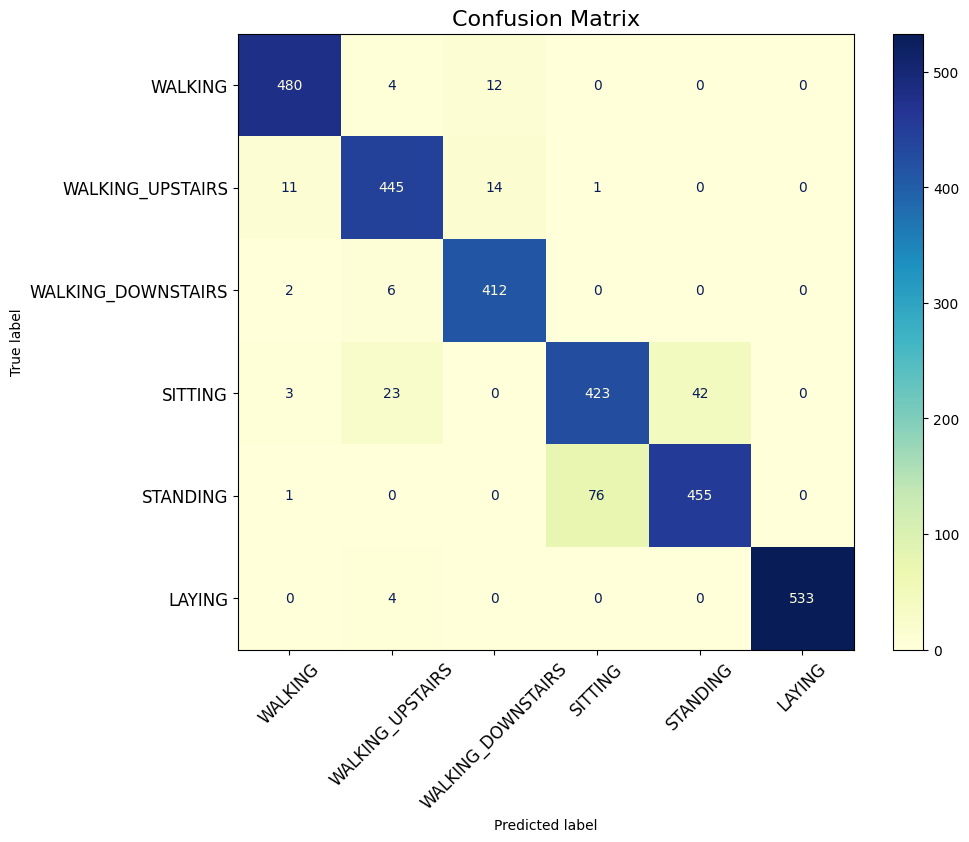

In [30]:
plot_confusion_matrix(model, test_loader, class_names=["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"])

## Log

---
RNN (180k) + Attention + KL Div + Adam + CosineAnnealingLR ->  Train Acc: 0.9606; Val Acc: 0.9192 \
TCN (56k) + KL Div + Adam + StepLR -> Train Acc: 0.9698; Val Acc: 0.9355 \
TCN (56k) + KL Div + Adam + ConsineAnnealineLR -> Train Acc: 0.9921; Val Acc: 0.9382 \
TCN (250k) + KL Div + Adam + ConsineAnnealingLR -> Train Acc: 0.9871; Val Acc: 0.9484 \
TCN (50k) + CBAM + KL Div + Adam + CosineAnnealingLR -> Train Acc: 0.9744; Val Acc: 0.9430

In [31]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  17450 KiB | 117861 KiB |   1412 GiB |   1412 GiB |\n|       from large pool |  16640 KiB | 116096 KiB |   1384 GiB |   1384 GiB |\n|       from small pool |    810 KiB |   3435 KiB |     27 GiB |     27 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         |  17450 KiB | 117861 KiB |   1412 GiB |   1412 GiB |\n|       from large pool |  16640 KiB | 116096 KiB |